In [1]:
import pygenten as gt
import pyttb as ttb
import numpy as np
import matplotlib.pyplot as plt
import copy as cpy

In [2]:
def t_slice(u,t):
    # take a slice of a ktensor from a given t index
    ut = u.copy()
    tmp = ut.factor_matrices[-1]
    tmp = np.reshape(tmp[t,:],(1,-1))
    ut.factor_matrices[-1] = tmp
    return ut

class SynGaussTensor:
    def __init__(self, shape, T, rank, noise):
        self.shape = shape
        self.T = T
        self.rank = rank
        self.noise = noise

        full_shape = self.shape + (T,)

        # construct underlying ktensor
        self.u_true = ttb.ktensor.from_function(np.random.random_sample, full_shape, rank)
        self.u_true.weights = np.random.random_sample(rank)
        self.u_true.normalize(None).redistribute(self.u_true.ndims-1) # normalize factor matrix columns and put all weight in time mode

        # construct full unperturbed tensor
        self.X = self.u_true.full()

        # time slice counter
        self.t = 0

    def draw(self):
        # reset counter based on period
        if self.t >= self.T:
            self.t = 0

        # get slice t of unperturbed data including a unit-length time-mode
        ind = [slice(None)]*self.X.ndims 
        ind[-1] = self.t
        Xt = self.X.data[tuple(ind)] # same as X[:,:,...,t]
        Xt = np.reshape(Xt,Xt.shape+(1,))
        Xt = ttb.tensor(Xt)

        # get slice t of corressponding ktensor
        ut = t_slice(self.u_true,self.t)

        # construct noise tensor for slice t
        Zt = ttb.tensor.from_function(np.random.standard_normal, self.shape+(1,))

        Xt += (self.noise*Xt.norm()/Zt.norm())*Zt

        # increment time counter
        self.t += 1

        return Xt,ut
    
def gaussian_reconstruction_error(u,X):
    # Compute reconstruction error between U and X for each time slice.
    # u is a ktensor
    # X is a list of tensor slices
    nt = u.shape[-1]
    r = np.zeros(nt)
    for t in range(nt):
        u_t = t_slice(u,t)
        r[t] = (u_t.full()-X[t]).norm()**2 / X[t].norm()**2
    return r

def compute_score(u, u_true):
    # Compute ktensor score for each slice
    nt = u.shape[-1]
    s = np.zeros(nt)
    for t in range(nt):
        u_t = t_slice(u,t)
        u_true_t = t_slice(u_true,t)
        score,_,_,_ = u_true_t.score(u_t)
        s[t] = score
    return s

def tensor_to_sptensor(X):
    # convert a dense tensor to sparse (same as X.to_sptensor(), but yields subs with 'C' order suitable for GenTen)
    idx = np.nonzero(np.ravel(X.data, order="F"))[0]
    subs = np.array(np.unravel_index(idx, X.shape, order="F"),order='F').transpose()
    vals = X.data[tuple(subs.T)][:, None]
    return ttb.sptensor(subs, vals, X.shape, copy=False)

In [3]:
syn_noise = 0.2
syn_rank = 20
syn_shape = (300,300)
syn_T = 200
num_time = syn_T
num_warm = 10
rank = syn_rank

In [4]:
# generate synthetic data
np.random.seed(13) # set seed so we always get the same tensor
syn = SynGaussTensor(syn_shape, syn_T, syn_rank, syn_noise)
all_data = np.zeros((*syn_shape,syn_T))
slices = []
u_true_slice = []
for t in range(num_time):
    data,ut = syn.draw()
    all_data[:,:,t] = data.data[:,:,0]
    slices.append(data)
    u_true_slice.append(ut)
X = ttb.tensor(all_data)
X0 = X[:,:,0:num_warm]

In [5]:
# generate warm start
# u0 = syn.u_true.copy()
# u0.factor_matrices[-1] = u0.factor_matrices[-1][0:num_warm,:]
u_init,_ = gt.cp_als(X0,rank=rank,mttkrp_method=gt.MttkrpPhan,tol=1e-6,maxiters=1000)#,init=u0)
u_init.normalize(None).redistribute(2) # normalize factor matrix columns and put all weight in time mode
reconstruction_init = gaussian_reconstruction_error(u_init,slices)


Dense tensor: 
  300 x 300 x 10 (900000 total entries)
  1.3e+03 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 processes (1 total)
  Execution space: openmp (8 threads)

CP-ALS:
  CP Rank: 20
  MTTKRP method: phan
  Gram formulation: symmetric

Iter   1: fit =  7.927179e-01 fitdelta =  2.1e-01
Iter   2: fit =  7.990990e-01 fitdelta =  6.4e-03
Iter   3: fit =  8.006759e-01 fitdelta =  1.6e-03
Iter   4: fit =  8.014336e-01 fitdelta =  7.6e-04
Iter   5: fit =  8.019094e-01 fitdelta =  4.8e-04
Iter   6: fit =  8.022608e-01 fitdelta =  3.5e-04
Iter   7: fit =  8.025453e-01 fitdelta =  2.8e-04
Iter   8: fit =  8.027899e-01 fitdelta =  2.4e-04
Iter   9: fit =  8.030074e-01 fitdelta =  2.2e-04
Iter  10: fit =  8.032041e-01 fitdelta =  2.0e-04
Iter  11: fit =  8.033840e-01 fitdelta =  1.8e-04
Iter  12: fit =  8.035506e-01 fitdelta =  1.7e-04
Iter  13: fit =  8.037064e-01 fitdelta =  1.6e-04
Iter  14: fit =  8.038529e-01 fitdelta =  1.5e-04
Iter  15: fit =  8.039902e-01 fitdelta 

In [6]:
# compute static cp decomposition
u_cp,_ = gt.cp_als(X,rank=rank,mttkrp_method=gt.MttkrpPhan,tol=1e-7,maxiters=1000)
reconstruction_cp_als = gaussian_reconstruction_error(u_cp,slices)
score_cp = compute_score(u_cp,syn.u_true)
syn.u_true.score(u_cp)[0]


Dense tensor: 
  300 x 300 x 200 (1.800000e+07 total entries)
  5.9e+03 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 processes (1 total)
  Execution space: openmp (8 threads)

CP-ALS:
  CP Rank: 20
  MTTKRP method: phan
  Gram formulation: symmetric

Iter   1: fit =  7.833972e-01 fitdelta =  2.1e-01
Iter   2: fit =  7.931154e-01 fitdelta =  9.7e-03
Iter   3: fit =  7.954842e-01 fitdelta =  2.4e-03
Iter   4: fit =  7.971669e-01 fitdelta =  1.7e-03
Iter   5: fit =  7.983982e-01 fitdelta =  1.2e-03
Iter   6: fit =  7.993203e-01 fitdelta =  9.2e-04
Iter   7: fit =  7.999543e-01 fitdelta =  6.3e-04
Iter   8: fit =  8.004635e-01 fitdelta =  5.1e-04
Iter   9: fit =  8.008748e-01 fitdelta =  4.1e-04
Iter  10: fit =  8.012071e-01 fitdelta =  3.3e-04
Iter  11: fit =  8.015172e-01 fitdelta =  3.1e-04
Iter  12: fit =  8.018041e-01 fitdelta =  2.9e-04
Iter  13: fit =  8.020233e-01 fitdelta =  2.2e-04
Iter  14: fit =  8.022105e-01 fitdelta =  1.9e-04
Iter  15: fit =  8.023741e-01 fi

np.float64(0.852077357365333)

In [7]:
# compute static gcp decomposition
gcp_params = dict()
gcp_params['type'] = 'gaussian'
gcp_params['sampler'] = 'uniform'
gcp_params['fnzs'] = 100000
gcp_params['gnzs'] = 100000
gcp_params['hash'] = True
gcp_params['fuse'] = True
gcp_params['maxiters'] = 100
gcp_params['fails'] = 2
gcp_params['fit'] = True
u_static_gcp,_ = gt.gcp_sgd(X,rank=rank,**gcp_params)
reconstruction_static_gcp = gaussian_reconstruction_error(u_static_gcp,slices)
score_static_gcp = compute_score(u_static_gcp,syn.u_true)
syn.u_true.score(u_static_gcp)[0]


Dense tensor: 
  300 x 300 x 200 (1.800000e+07 total entries)
  5.9e+03 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 processes (1 total)
  Execution space: openmp (8 threads)

GCP-SGD (Generalized CP Tensor Decomposition):
Generalized function type: Gaussian (normal)
Optimization method: adam
Max iterations (epochs): 100
Iterations per epoch: 1000
Traditional annealer, learning rate: 1.0e-03, decay: 1.0e-01
  Function sampler:  uniform with 100000 samples
  Gradient sampler:  uniform with 100000 samples
  Gradient samples per epoch: 100000000 (555.6%)
Gradient method: Fused sampling and duplicated MTTKRP

Initial f-est:  6.392462e+06, fit:  5.746e-01, tensor norm:  5.932e+03
Epoch   1: f-est =  1.700726e+06, fit =  7.807e-01, step =  1.0e-03, time = 4.92e+00 sec
Epoch   2: f-est =  1.458035e+06, fit =  7.969e-01, step =  1.0e-03, time = 9.65e+00 sec
Epoch   3: f-est =  1.411199e+06, fit =  8.003e-01, step =  1.0e-03, time = 1.45e+01 sec
Epoch   4: f-est =  1.393948e+06

np.float64(0.825466588896244)

In [8]:
# temporal sgd solver params
temporal_params = dict()
temporal_params['sampling'] = 'uniform'
temporal_params['fnzs'] = 10000
temporal_params['gnzs'] = 10000
temporal_params['hash'] = True
temporal_params['fuse'] = True
temporal_params['maxiters'] = 20
temporal_params['fails'] = 3
temporal_params['epochiters'] = 10
temporal_params['rate'] = 10
temporal_params['fit'] = True
temporal_params['gcp-tol'] = 1e-5

# spatial sgd solver params
spatial_params = cpy.deepcopy(temporal_params)
spatial_params['maxiters'] = 5
spatial_params['rate'] = 1e-4

# streaming solver params
gcp_params = dict()
gcp_params['streaming-solver'] = 'sgd'
gcp_params['type'] = 'gaussian'
gcp_params['rank'] = rank
gcp_params['window-size'] = 50
gcp_params['window-method'] = 'reservoir'
gcp_params['printitn'] = 10

# compute streaming gcp decomposition
u_gcp,fest,ften = gt.online_gcp(slices[num_warm:],X0,u_init,temporal_params,spatial_params,**gcp_params)
u_gcp.normalize(None).redistribute(2)
u_gcp.factor_matrices[-1] = np.vstack((u_init.factor_matrices[-1],u_gcp.factor_matrices[-1]))
global_reconstruction_gcp = gaussian_reconstruction_error(u_gcp,slices)
local_reconstruction_gcp = list(reconstruction_init) + [ f/s.norm()**2 for f,s in zip(ften,slices) ]
score_gcp = compute_score(u_gcp,syn.u_true)
syn.u_true.score(u_gcp)[0]


Online-GCP (Online Generalized CP Tensor Decomposition)

Rank: 20
Generalized function type: Gaussian (normal)


Streaming window size: 50 (reservoir), penalty: 1.00e+00 * ( 1.00e+00 )^(T-t)

Processing slice 10 of 190
Solving for temporal mode...
Initial f-est:  1.282838e+04, fit:  7.303e-01, tensor norm:  4.207e+02
Epoch   1: f-est =  7.479943e+03, fit =  7.934e-01, step =  1.0e+01, time = 8.02e-03 sec
Epoch   2: f-est =  6.930839e+03, fit =  8.011e-01, step =  1.0e+01, time = 1.65e-02 sec
Epoch   3: f-est =  6.908760e+03, fit =  8.014e-01, step =  1.0e+01, time = 2.41e-02 sec
Epoch   4: f-est =  6.940216e+03, fit =  8.012e-01, step =  1.0e+01, time = 3.20e-02 sec, nfails = 1 (resetting to solution from last epoch)
Epoch   5: f-est =  6.886918e+03, fit =  8.019e-01, step =  1.0e+00, time = 3.91e-02 sec
Epoch   6: f-est =  6.845665e+03, fit =  8.024e-01, step =  1.0e+00, time = 4.68e-02 sec
Epoch   7: f-est =  6.825159e+03, fit =  8.027e-01, step =  1.0e+00, time = 5.42e-02 sec
Epoch   8: f-est =  6.818543e+03, fit =  8.027e-01, step =  1.0e+00, time = 6.18e-02 sec
Epoch   9: f-est =  6.816332e+

np.float64(0.8012392191016178)

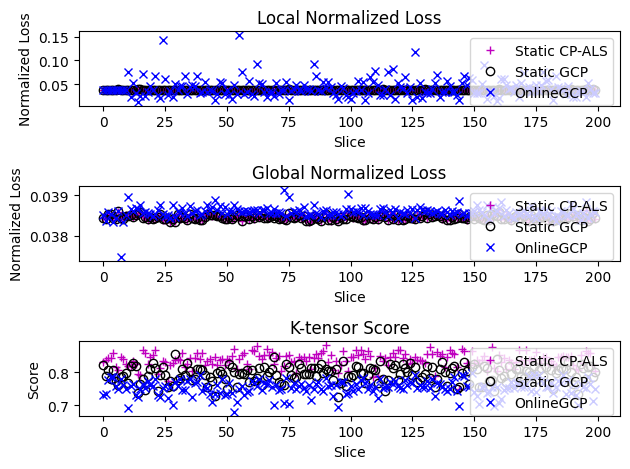

In [9]:
# plot reconstruction errors and scores
fig, axs = plt.subplots(3,1)
axs[0].plot(reconstruction_cp_als, 'm+', label='Static CP-ALS')
axs[0].plot(reconstruction_static_gcp, 'ko', label='Static GCP', markerfacecolor='none')
axs[0].plot(local_reconstruction_gcp, 'bx', label='OnlineGCP', markerfacecolor='none')
axs[0].set_title('Local Normalized Loss')
axs[0].set_xlabel('Slice')
axs[0].set_ylabel('Normalized Loss')
axs[0].legend(loc='upper right')

axs[1].plot(reconstruction_cp_als, 'm+', label='Static CP-ALS')
axs[1].plot(reconstruction_static_gcp, 'ko', label='Static GCP', markerfacecolor='none')
axs[1].plot(global_reconstruction_gcp, 'bx', label='OnlineGCP', markerfacecolor='none')
axs[1].set_title('Global Normalized Loss')
axs[1].set_xlabel('Slice')
axs[1].set_ylabel('Normalized Loss')
axs[1].legend(loc='upper right')

axs[2].plot(score_cp, 'm+', label='Static CP-ALS')
axs[2].plot(score_static_gcp, 'ko', label='Static GCP', markerfacecolor='none')
axs[2].plot(score_gcp, 'bx', label='OnlineGCP', markerfacecolor='none')
axs[2].set_title('K-tensor Score')
axs[2].set_xlabel('Slice')
axs[2].set_ylabel('Score')
axs[2].legend(loc='upper right')

fig.tight_layout()